In [2]:
from model_seir.kernel import main, progress_bar
from model_seir.configuration import read_configuration, save_configuration, update_configuration, save_deaths_list
from model_seir.evolution import evolve
from model_seir.parameters_control import Params_Manager, param_to_index, fixed_params_to_index
from model_seir.analysis import open_save_files, median, percentil
import cupy as cp
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib import cm


SAVE_DATA = True
ANALYZE_DATA = True
ERASE_PREV_DATA = True

TOTAL_ITERATIONS = 2

country = "SEIR"

In [3]:
configuration_ref = read_configuration(country, sufix='', prefix='used/', v2=True)
configuration = configuration_ref.copy()
configuration["simulation"]["n_simulations"] = 500
max_days = configuration["max_days"]


lambda_ = 0.2
initial_i_ = 60e-6
mu_ = 0.07
eta_ = 0.08

objective_params = np.array([lambda_, initial_i_])
best_params = np.array([0.2, 60.00299680788351e-06])
fixed_params = np.array([eta_, mu_])

In [4]:
def log_diff_funciton(t, deaths):
    diff = np.abs(deaths-deaths_list[t])
    return np.log(diff+1)

def diff_funciton(t, deaths):
    diff = np.abs(deaths-deaths_list[t])
    return diff+1

In [5]:
objective_state = np.zeros(4, dtype=cp.float64)
objective_state[0] = 1-objective_params[param_to_index['initial_i']]
objective_state[2] = objective_params[param_to_index['initial_i']]

best_state = np.zeros(4, dtype=cp.float64)
best_state[0] = 1-best_params[param_to_index['initial_i']]
best_state[2] = best_params[param_to_index['initial_i']]

new_max_days = max_days+100

susceptible = np.zeros(new_max_days)
expuestos = np.zeros(new_max_days)
infected = np.zeros(new_max_days)
deaths_list = np.zeros(new_max_days)
deaths_list_best = np.zeros(new_max_days)

time = 0
log_diff = 0

while time<new_max_days:
    evolve(objective_params, fixed_params, objective_state) 
    evolve(best_params, fixed_params, best_state)
    
    susceptible[time] = objective_state[0]*configuration["total_population"]
    expuestos[time] = objective_state[1]*configuration["total_population"]
    infected[time] = objective_state[2]*configuration["total_population"]
    deaths_list[time] = objective_state[3]*configuration["total_population"]
    deaths_list_best[time] = best_state[3]*configuration["total_population"]
    log_diff += log_diff_funciton(time, deaths_list_best[time])
    time += 1
    
# save_deaths_list(country, deaths_list)

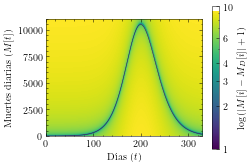

In [6]:
import matplotlib.colors as colors
plt.style.use('science')
# with plt.style.context(['science', 'notebook']):
fig, ax = plt.subplots()


X, Y = np.meshgrid(np.arange(new_max_days), np.linspace(0, max(deaths_list)*1.05, new_max_days*20))
log_diff = log_diff_funciton(X, Y)

norm=colors.LogNorm(vmin=1, vmax=log_diff.max(), clip=True)
img = ax.imshow(log_diff, norm=norm, extent=[X.min(), X.max(), Y.min(), Y.max()], origin='lower', alpha=1)
ax.plot(deaths_list, c=cm.viridis(norm(1)), lw=0.5)

ax.set_ylabel(r"Muertes diarias ($M[t]$)")
ax.set_xlabel(r"Días ($t$)")

# ax.plot(deaths_list[:new_max_days], color='black')
ax.set_aspect(6*X.max()/(8*Y.max()))

cb = fig.colorbar(img, label=r"$\log\left( \left| M[i] - M_D[i] \right|+ 1 \right)$", ax=ax, norm=norm)
cb.set_ticks([1, 2, 3, 4, 6, 10], labels=["1", "2", "3", "4", "6", "10"], minor=False)

fig.savefig(f'images/images_by_country/{country}/funcion objetivo.pdf')
    # plt.legend()



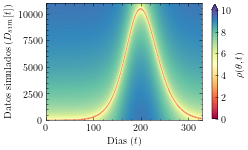

In [8]:
import matplotlib.colors as colors
plt.style.use('science')
# with plt.style.context(['science', 'notebook']):
fig, ax = plt.subplots()


X, Y = np.meshgrid(np.arange(new_max_days), np.linspace(0, max(deaths_list)*1.05, new_max_days))
log_diff = log_diff_funciton(X, Y)

cmap = cm.get_cmap("Spectral")

# norm=colors.LogNorm(vmin=1, vmax=max(log_diff.max(), 10), clip=True)
norm=colors.Normalize(vmin=0, vmax=max(log_diff.max(), 10), clip=True)
img = ax.pcolormesh(X, Y, log_diff, cmap=cmap, norm=norm, alpha=1, shading='gouraud') # extent=[X.min(), X.max(), Y.min(), Y.max()], origin='lower',
ax.plot(deaths_list, c=cmap(norm(1)), lw=0.3)

ax.set_ylabel(r"Datos simulados ($D_{sim}[t]$)")
ax.set_xlabel(r"Días ($t$)")

# ax.plot(deaths_list[:new_max_days], color='black')
ax.set_aspect(6*X.max()/(8*Y.max()))

# cb = fig.colorbar(img, label=r"$log\left(\left| M[i] - M_D[i] \right|+ 1 \right)$", ax=ax, norm=norm, shrink=0.8, extend='max')
cb = fig.colorbar(img, label=r"$\rho (\theta, t)$", ax=ax, norm=norm, shrink=0.8, extend='max')
# cb.set_ticks([1, 10, 100, 1000, 10000], labels=["1", r"$10^1$", r"$10^2$", r"$10^3$", r"$10^4$"])
cb.set_ticks([0, 10], labels=["0", r"$10$"], minor=True)

fig.savefig(f'images/images_by_country/{country}/funcion objetivo.pdf')
    # plt.legend()



In [5]:
files_length = 1000
files = {}
for i, (n_simulations, p) in enumerate(zip([1e4, 1e5, 1e6], [10, 1, 0.1])):
    files.update({p : open_save_files(country, mode='r', sufix=f'_{p}')})

In [6]:


log_diff = np.zeros([len(files.keys()), files_length])
for j, p in enumerate([10, 1, 0.1]):
    for i,value in enumerate(files[p]['log_diff']):
        log_diff[j,i] = np.float64(value)

In [9]:
for k_, f_ in files.items():
    for k, f in f_.items():
        f.seek(0)

# Por cada parámetro hacemos la comparación de todos los archivos
for k in files[1]:
    if k in ['recovered', 'log_diff']:
        continue

    params = np.zeros([len(files.keys()), files_length])


    for j, p in enumerate([10, 1, 0.1]):
        for i, value in enumerate(files[p][k]):
            params[j, i] = np.float64(value)

    weights = np.exp(-log_diff/log_diff.min(0))

    
    with plt.style.context('science'):
        fig, ax = plt.subplots()
        for j, (p, c, exponente) in enumerate(zip([0.1, 1, 10], ['blue', 'green', 'red'], [4,5,6])):
            k_array = params[j].copy()
        
            k_array_copy = k_array.copy()
            k_array_copy.sort()

            k_array_median = median(k_array)
            print(k)
            print(k_array.mean())
            print(k_array.std())
            k_array_percentil_5 = percentil(k_array, 5)
            k_array_percentil_95 = percentil(k_array, 95)


            x = np.linspace(start=k_array.min(), stop=k_array.max(), num=250)

            if k!='log_diff':
                bins = np.linspace(k_array.min(), k_array.max(), 20)
                # ax.hist(k_array, bins=bins, density=True, weights=weights[j], alpha=0.5, linewidth=0.8, edgecolor="tab:grey", fill=False)
                gkde = stats.gaussian_kde(dataset=k_array, weights=weights[j])
            else:
                ax.hist(k_array, 20, density=True, alpha=0.3)
                gkde = stats.gaussian_kde(dataset=k_array)


            ax.plot(x, gkde.evaluate(x), linestyle='solid', lw=1.3, alpha=0.7, color=c, label="$10^{"+str(exponente)+"}$")
            ax.fill_between(x, np.zeros(x.shape[0]), gkde.evaluate(x), alpha=0.4, color=c)
            
            # ax.set_yticks([])
            # ax.set_yticklabels([])
            
            # y_min, y_max = ax.get_ylim()
            # y_dist = y_max-y_min
            # ax.vlines(k_array_median, ymin=y_min, ymax=gkde.evaluate(k_array_median), label='Mediana', color='orange')
            # ax.vlines(k_array_percentil_5, ymin=y_min, ymax=gkde.evaluate(k_array_percentil_5), label='Percentil 5', color='red')
            # ax.vlines(k_array_percentil_95, ymin=y_min, ymax=gkde.evaluate(k_array_percentil_95), label='Percentil 95', color='purple')
            
            
            # ax.set_ylim(ymin=0)
            # ax.set_xlim(x.min(), x.max())
            # ax.set_title(k.capitalize())

        label = {
            'lambda' :  r"$\lambda$",
            'permeability' : r"$\phi$",
            'initial_i' : r"$I/N[t=0]$",
            'what' : r"$\xi$",
            'offset' : r"$offset$",
            'IFR' : r"$IFR$",
            'log_diff' : r"Distancia a función objetivo",
            'eta': r"$\eta$",
            'mu': r"$\mu$"
        }[k]
        
        # if k=='initial_i':
        #     ax.set_xscale('log')
        ax.set_ylabel('Frecuencia relativa')
        ax.set_yticklabels([])
        ax.set_xlabel(label)
        ax.set_ylim(ymin=0)


        if k=='initial_i':
            def formater(x, pos):
                # if x>0:
                #     exp = int(np.log10(x))+1
                #     x_plane = x* np.power(10.0, exp)
                #     return f"${x_plane:.1f}"+"\cdot10^{"+str(exp)+"}$"
                return f"{x:.0e}"
                
            ax.xaxis.set_major_formatter(formater)
        # ax.set_yscale('log')
        # ax.set_title(label)
        # else:
        #     # from matplotlib.ticker import NullFormatter
        #     # nullfmt = NullFormatter()
        #     # ax.yaxis.set_major_formatter(nullfmt)
        
        ax.legend(title=r'\# simulaciones')
        
        fig.savefig(f'images\images_by_country\{country}\{k}_noice_plots.png')
        fig.savefig(f'images\images_by_country\{country}\{k}_noice_plots.pdf')
        plt.close(fig)

lambda
0.20141085586672822
0.014440572857370647
lambda
0.19967278843240371
0.004406358048894507
lambda
0.19999648548248497
0.0014573982123245598
initial_i
5.9491372612056434e-05
2.3032696691788267e-05
initial_i
6.162649299034205e-05
9.878447983879995e-06
initial_i
6.008102395521166e-05
3.429740852500444e-06
